In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output as clr
import os
import numpy as np

In [2]:
device = "cpu"
if(torch.cuda.is_available()):
    deivce = "gpu"

torch.autograd.set_detect_anomaly(True)

In [3]:
# training
BATCH_SIZE = 100
if(os.path.isdir(os.path.join(os.getcwd(), 'data'))):
    trainset = datasets.MNIST('./data/', train=True, download=False,
                   transform=transforms.ToTensor())
else:
    trainset = datasets.MNIST('./data/', train=True, download=True,
                   transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
print("Done !")

Done !


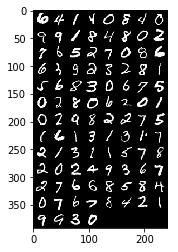

In [4]:
def show_images(images):
    images = torchvision.utils.make_grid(images)
    show_image(images[0])

def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
show_images(images)

In [138]:
class VAE_NP(nn.Module):
    def __init__(self, latent_variable_dim, alpha = 1.0, rholr = 10e-12):
        super(VAE_NP, self).__init__()
        
        ### Global Params
        self.eps1 = torch.tensor(10e-6).float()
        self.eps2 = torch.tensor(10e-4).float()
        
        # V : Stick breaking : Beta {kumaraswamy}
        self.aeys = nn.Parameter(torch.rand(1,latent_variable_dim) + 1)
        self.bees = nn.Parameter(torch.rand(1,latent_variable_dim) + 1)
        
        self.unif_sampler = torch.distributions.uniform.Uniform(0, 1)
        
        
        # IBP prior
        self.alpha = alpha
        self.euler_constant = np.e
        
        ### Encoder part
        self.fc1 = nn.Linear(784, 400)
        
        # A : Gaussian
        self.weight_enc_mean = nn.Parameter(torch.randn(latent_variable_dim, 400)*0.01)
        self.weight_enc_std = nn.Parameter(torch.randn(latent_variable_dim, 400)*0.1)
        
        # Z : Bernoulli
        self.phi = nn.Parameter(torch.randn((784 + 1),latent_variable_dim)*0.001)
        
        # Gumbel Softmax params
        self.temperature = 10
        self.t_prior = 0.1 # prior lambda
        self.gumbel_sampler = torch.distributions.gumbel.Gumbel(0,1)
        
        ### Decoder part
        self.weight_dec = nn.Parameter(torch.randn(400, latent_variable_dim, )*0.01)
        
        self.fc4 = nn.Linear(400, 784)
        
        ### Russian Roulette part
        self.rhos = torch.zeros(latent_variable_dim + 1,1) + 0.5
        self.rholr = rholr
        
        ## Optimizer
        self.optimizer = None
        self.K = latent_variable_dim
        self.max_K = latent_variable_dim
        
    
    def reparameterize_gaussian(self, log_var, mu):
        s = torch.exp(0.5*log_var)+self.eps2
        eps = torch.rand_like(s)-0.5 # generate a iid standard normal same shape as s
        return eps.mul(s).add_(mu)
    
    def reparameterize_gumbel_kumaraswamy(self, inter_z):
        
        N, K = inter_z.shape
        sample_size = 1
        
        U = self.unif_sampler.sample([N,K,sample_size])
        G1 = self.unif_sampler.sample([N,K,sample_size])
        logit_G1 = G1.log() - (1-G1).log() 
        
        V = (1-U.pow(1/self.aeys[:,:K].view(-1,K,1))).pow(1/self.bees[:,:K].view(-1,K,1))
        
        pi = torch.zeros_like(V)+1
        for i in range(K):
            for j in range(i+1):
                pi[:,i,:] *= V[:,j,:]
        
        rand_num = torch.rand_like(pi)
        rand_logit = (rand_num/(1-rand_num)).log()
        
        
        logit_pi = ((pi + self.eps1)/(1-pi + self.eps1)).log()
        alpha = (logit_pi + inter_z.view(N,K,1)).sigmoid().pow(0.98)
        logit_alpha = (alpha + self.eps1)/(1-alpha + self.eps1)
        
        z1 = (logit_alpha.log() + logit_G1)/self.temperature
        
        y = z1.sigmoid()
        
        
        return y, alpha, pi
    
    def forward(self, input, k):
        x = input.view(-1, 784)
        N, D = x.shape
        x = torch.relu(self.fc1(x))
        
        if(k == 0):
            k = self.get_current_K()
        
        log_s = F.linear(x, self.weight_enc_std[:k,:])
#         log_s[log_s>10]=10.0
#         log_s[log_s<-10]=-10.0
        m = F.linear(x, self.weight_enc_mean[:k,:])
        
        inter_z = self.phi # 785 x K
        x_cat = torch.cat((input.view(N,784), torch.ones(N).view(N,-1)), 1).view(N,785) # N x 785
        inter_z = F.linear(x_cat, inter_z[:,:k].transpose(0,1)) # N x K
        
        
        z, gi, pi = self.reparameterize_gumbel_kumaraswamy(inter_z) # N x K
        
        a = self.reparameterize_gaussian(log_s, m) # N x K
        
        az = a*(z.mean(dim = -1).view(N,k))
        
        x = self.decode(a, k)
        
        return x, m, log_s, z, pi, gi

    
    def decode(self, z, k):
        x = torch.relu(F.linear(z, self.weight_dec[:,:k]))
        x = self.fc4(x)
        x = torch.sigmoid(x)
        
        
        
        return x
    
    
    def add_k_node(self, k):
        # Add k latent features ...
        if(k == 0):
            return 
        with torch.no_grad():
            self.aeys = nn.Parameter(torch.cat((self.aeys, torch.rand(1,k) + 1), 1))
            self.bees = nn.Parameter(torch.cat((self.bees, torch.rand(1,k) + 1), 1))
            
            self.phi = nn.Parameter(torch.cat((self.phi, torch.randn((784 + 1),k)), 1)*0.001)
            
            self.weight_enc_mean = nn.Parameter(torch.cat((self.weight_enc_mean, torch.randn(k, 400)), 0)*0.001)
            self.weight_enc_std = nn.Parameter(torch.cat((self.weight_enc_std, torch.randn(k, 400)), 0)*0.001)
            self.weight_dec = nn.Parameter(torch.cat((self.weight_dec, torch.randn(400,k)), 1)*0.001)
            
            self.rhos = torch.cat((self.rhos, torch.zeros(k,1) + 0.5), 0)
    
    def del_k_node(self, k):
        # Retain k Latent Features ...
        if(k == 0 or k == self.weight_dec.shape[1]):
            return
        with torch.no_grad():
            c_K = self.weight_dec.shape[1]
            
            self.aeys = nn.Parameter(list(torch.split(self.aeys, c_K - k , 1))[0])
            self.bees = nn.Parameter(list(torch.split(self.bees, c_K - k , 1))[0])
            
            self.phi = nn.Parameter(list(torch.split(self.phi, c_K - k , 1))[0])
            
            self.weight_enc_mean = nn.Parameter(list(torch.split(self.weight_enc_mean, c_K - k , 0))[0])
            self.weight_enc_std = nn.Parameter(list(torch.split(self.weight_enc_std, c_K - k , 0))[0])
            self.weight_dec = nn.Parameter(list(torch.split(self.weight_dec, c_K - k , 1))[0])
            
            self.rhos = list(torch.split(self.rhos, c_K - k + 1, 0))[0]
                             
    def get_current_K(self):
        return self.K
    

    def constraint_proj(self):
        with torch.no_grad():
            self.aeys[self.aeys < 0.001] = 0.001
            self.bees[self.bees < 0.001] = 0.001
            self.rhos[self.rhos < self.eps2] = self.eps2
            self.rhos[self.rhos > 1 - self.eps2] = 1 - self.eps2

In [43]:
def loss(input_image, recon_image):
    CE = F.binary_cross_entropy(recon_image, input_image.view(-1, 784), reduction='sum')
    return CE

In [151]:
def retain_k_nodes(model , new_K = 0):
    
    current_K = model.weight_dec.shape[1]
    if(current_K < new_K):
        model.add_k_node(new_K - current_K)
    elif(current_K > new_K):
        model.del_k_node(current_K - new_K)
    else:
        pass
    
    optimizer = torch.optim.Adam(model.parameters(), 0.05)
    
    return optimizer

In [141]:
def get_kth_trunc_loss(model, images, K = 0):
    N = images.shape[0]
    
    recon_image, log_var, mu, z, pi, gi = model(images, K)
#     print((recon_image != recon_image).sum())
    softplus = nn.Softplus()
    eps = model.eps1
    
    if(K == 0):
        K = model.aeys.shape[1]
    
    log_var = log_var[:,:K]
    mu = mu[:,:K]
    z = z[:,:K]
    pi = pi[:,:K]
    gi = gi[:,:K]
    
    
    KL_gauss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    KL_gauss /= N
    
    KL_kuma = ((model.aeys - model.alpha)/(model.aeys))*(-model.euler_constant -torch.digamma(model.bees) - 1/model.bees)
    KL_kuma += (model.aeys.log() + model.bees.log())
    KL_kuma += -(model.bees - 1)/(model.bees)
    
    KL_kuma = torch.sum(KL_kuma[:,:K])
    
    logit_pi = (pi+eps).log() - (1-pi+eps).log()
    logit_x  =  (z+eps).log() - (1 -z+eps).log()
    logit_gi = (gi+eps).log() - (1-gi+eps).log()

    tau = model.temperature
    tau_prior = model.t_prior
    
    exp_term_p = logit_pi - logit_x*(tau_prior)
    exp_term_q = logit_gi - logit_x*(tau)
    
    log_tau = torch.log(torch.tensor(model.temperature, requires_grad = False))
    
    
    
    log_pz = log_tau + exp_term_p - 2.0*softplus(exp_term_p)
    log_qz = log_tau + exp_term_q - 2.0*softplus(exp_term_q)
    
    KL_gumb = (log_qz - log_pz)
    
    KL_gumb[KL_gumb != KL_gumb] = 0
    KL_gumb[KL_gumb < 0] = 0
#     print(KL_gumb.shape)
    KL_gumb = torch.sum(KL_gumb.mean(dim =-1))#.abs()
    KL_gumb /= N
    
    
    l = loss(images, recon_image)/N
    KL_l  = KL_gauss + KL_kuma + KL_gumb
    
    print(l, KL_gauss, KL_kuma, KL_gumb)
    
    return l + KL_l

In [142]:
def rrs_loss(model, images, curr_K):
    
    l = torch.zeros(curr_K+1,1)
    for i in range(1,curr_K+1):
        l[i,:] = get_kth_trunc_loss(model, images, K = i)
        
    
    one_minus_rho = (1 - model.rhos[0:curr_K+1]).view(curr_K+1,1)
    
    return l, one_minus_rho

In [143]:
def train_step(model, images, sample_max = 5, sample = False, keep_graph = False):
    
    """ sample a trucation level and then do the same"""
    
    curr_K = model.get_current_K()
    model.rhos[0] = 1.0
    model.optimizer = retain_k_nodes(model , new_K = model.max_K+1)
    model.optimizer = retain_k_nodes(model , new_K = model.max_K)
    
    
    if(sample):
        
        curr_K = model.get_current_K()
        rhos = list(model.rhos)  
        
        L = len(rhos)
        
        samples = []
        for i in range(sample_max):
            
            k = 1
            while(True):
                u = np.random.uniform()
                if(u > rhos[k]):
                    samples.append(k)
                    break
                k += 1
                
                if(k > L-1):
                    rhos.append(0.5)
                

        new_value = int(np.max(samples))

        if(new_value > model.max_K):
            model.optimizer = retain_k_nodes(model , new_K = new_value)
            model.K = new_value
            model.max_K = new_value
        else:
            model.optimizer = retain_k_nodes(model , new_K = model.max_K)
            model.K = new_value
        
        
    else:
        new_value = curr_K
    
    

    print("Current Truncated Level :", new_value)
    print(model.rhos)
    model.optimizer.zero_grad()
    curr_K = model.get_current_K()
    
    
    l ,one_minus_rho = rrs_loss(model, images, curr_K)
    l[l != l] = 0
    l_final_params = (l*one_minus_rho).sum()
#     print(l,one_minus_rho,l_final_params)
    
    
    ws = torch.zeros(curr_K+1, curr_K)
    
    for k in range(1,curr_K+1):
        for i in range(k-1,curr_K):
            if(i < k-1):
                ws[k,i] = 0
            elif(i == k-1):
                ws[k,i] = 1/(model.rhos[k] - 1)
            else:
                ws[k,i] = 1/model.rhos[k]
            
    
    rho_grads = (ws*(-l)*one_minus_rho).sum(dim = 1)
    rho_grads[rho_grads != rho_grads] = 0.0
    rho_logit = ((model.rhos).log() - (1 - model.rhos).log())[:curr_K+1]
    sig_rho = rho_logit.sigmoid()
    
    
    rho_logit[:curr_K+1,:] = rho_logit[:curr_K+1,:] - model.rholr*(sig_rho*(1-sig_rho)*rho_grads.view(-1,1))
    model.rhos[:curr_K+1,:] = rho_logit.sigmoid()
    

    
    if(l_final_params != l_final_params):
        pass
    else:
        try:
            l_final_params.backward()
            model.optimizer.step()
        except:
            print("failed")

    model.constraint_proj()
    
    return l_final_params

In [148]:
vae = VAE_NP(2,10,10e-4)

In [149]:
## train
train_loss = []
vae.temperature = 10.0

In [ ]:
# optimizer = torch.optim.Adam(vae.parameters(), 0.01)
for epoch in range(50):
    
        
    for i, data in enumerate(trainloader, 0):
        images, labels = data
        images = images.to(device)

        if(i%1 == 0 and True):
            l = train_step(vae, images, 10, True)
        else:
            l = train_step(vae, images, 10, False)
        
        train_loss.append(l.item())

        vae.temperature /= 1.1
        if(vae.temperature < .5):
            vae.temperature = 0.5
        

#         optimizer.zero_grad()
#         l = get_kth_trunc_loss(vae, images, K = 0)
# #         try:
#         l.backward()
# #         except:
# #             pass
#         train_loss.append(l.item() / len(images))
#         optimizer.step()
    
        

        if(i%1 == 0):
            clr(wait = True)
            print("Epoch no :", epoch + 1, "batch_no :", i, "curr_loss :",  train_loss[-1])
        
plt.plot(train_loss)
plt.show()

Epoch no : 1 batch_no : 115 curr_loss : 699.93701171875
Current Truncated Level : 16
tensor([[1.0000],
        [0.9154],
        [0.9081],
        [0.8994],
        [0.8889],
        [0.8760],
        [0.8599],
        [0.8403],
        [0.8128],
        [0.7745],
        [0.7205],
        [0.6644],
        [0.5966],
        [0.5174],
        [0.4145],
        [0.5298],
        [0.5228],
        [0.4781],
        [0.4740]])
tensor(207.9773, grad_fn=<DivBackward0>) tensor(0.1327, grad_fn=<DivBackward0>) tensor(4.3396, grad_fn=<SumBackward0>) tensor(0.0280, grad_fn=<DivBackward0>)
tensor(207.4175, grad_fn=<DivBackward0>) tensor(0.2653, grad_fn=<DivBackward0>) tensor(8.9653, grad_fn=<SumBackward0>) tensor(0.0651, grad_fn=<DivBackward0>)
tensor(206.6666, grad_fn=<DivBackward0>) tensor(0.3980, grad_fn=<DivBackward0>) tensor(13.5959, grad_fn=<SumBackward0>) tensor(0.1424, grad_fn=<DivBackward0>)
tensor(205.9124, grad_fn=<DivBackward0>) tensor(0.5109, grad_fn=<DivBackward0>) tensor(18.0712, g

In [ ]:
with torch.no_grad():
    for i, data in enumerate(testloader, 7):
        images, labels = data
        images = images.to(device)
        recon_image, s, mu, z, pi, gi = vae(images, 0)
        recon_image_ = recon_image.view(BATCH_SIZE, 1, 28, 28)
        if i % 100 == 0:
            show_images(recon_image_)

In [15]:
# test
testset = datasets.MNIST('./data/', train=False, download=False,
                   transform=transforms.ToTensor())

testloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

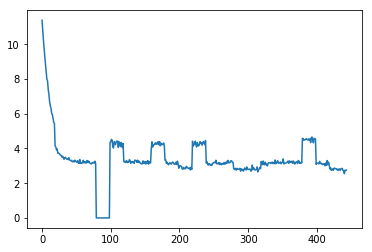

In [245]:
temp = np.array(train_loss)
plt.plot(temp*(temp < 20000))

In [246]:
min(temp[:])

2.5503184509277346

In [247]:
vae.rholr

0.0001

In [248]:
vae.rhos[vae.rhos != vae.rhos] = 0.5

In [249]:
vae.rhos

tensor([[1.0002],
        [0.4967],
        [0.3939],
        [0.4711],
        [0.4755],
        [0.4924]], grad_fn=<IndexPutBackward>)

In [250]:
vae.temperature

0.05

In [251]:
vae.aeys

Parameter containing:
tensor([[36.4143, 35.6425,  5.6646,  3.7565,  1.7652]], requires_grad=True)

In [252]:
vae.bees

Parameter containing:
tensor([[1.4245, 3.1288, 0.8362, 0.5595, 0.8873]], requires_grad=True)